Clustering with K-means for eCommerce
=====================================

[RFM Analysis](https://medium.com/mlearning-ai/crm-analytics-customer-segmentation-customer-lifetime-value-prediction-1163fa6e4ae9): Understand customers' buying patterns using 3 'customer lifetime value' metrics: 
- Recency (how many days ago was their last purchase?)
- Frequency (how many times did they purchase?) 
- Monetary (how much money did they spend?)


## 1. Import modules and data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import style

#%matplotlib inline #added because ipympl was breaking seaborn
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore')

from sklearn import preprocessing, metrics, cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances


In [2]:
# load csv
dataset = pd.read_csv('./Data/Sample-Superstore-cleaner.csv')

df = dataset.copy() # keep dataset as a backup copy, use df for transformations

df.head() # check it's there and properly separated into columns

,row_id,order_id,order_date,ship_date,customer_id,segment,product_id,category,subcategory,product_name,quantity,discount_perc,sale_price_agg,profit_agg,sale_price_per_item,profit_per_item,base_price_per_item
0,1,CA-2016-152156,11/8/2016,11/11/2016,CG-12520,Consumer,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,2,0.00,261.9600,41.9136,130.9800,20.9568,130.98
1,2,CA-2016-152156,11/8/2016,11/11/2016,CG-12520,Consumer,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",3,0.00,731.9400,219.5820,243.9800,73.1940,243.98
2,3,CA-2016-138688,6/12/2016,6/16/2016,DV-13045,Corporate,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,2,0.00,14.6200,6.8714,7.3100,3.4357,7.31
3,4,US-2015-108966,10/11/2015,10/18/2015,SO-20335,Consumer,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,5,0.45,957.5775,-383.0310,191.5155,-76.6062,348.21
4,5,US-2015-108966,10/11/2015,10/18/2015,SO-20335,Consumer,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,2,0.20,22.3680,2.5164,11.1840,1.2582,13.98


### Transform into an aggregated DataFrame 
Form one table storing Recency (today - order date, in days) Frequency (count of unique order ids) and Monetary (sum of sales) for each Customer ID 

First we need to make sure we have the right datatype for `order_date` in order to perform arithmetic on the field:

In [3]:
print(df.dtypes)

row_id                   int64
order_id                object
order_date              object
ship_date               object
customer_id             object
segment                 object
product_id              object
category                object
subcategory             object
product_name            object
quantity                 int64
discount_perc          float64
sale_price_agg         float64
profit_agg             float64
sale_price_per_item    float64
profit_per_item        float64
base_price_per_item    float64
dtype: object


The datatype needs to be converted:

In [4]:
df.order_date = pd.to_datetime(df.order_date)
print(df.dtypes)

row_id                          int64
order_id                       object
order_date             datetime64[ns]
ship_date                      object
customer_id                    object
segment                        object
product_id                     object
category                       object
subcategory                    object
product_name                   object
quantity                        int64
discount_perc                 float64
sale_price_agg                float64
profit_agg                    float64
sale_price_per_item           float64
profit_per_item               float64
base_price_per_item           float64
dtype: object


Because this data is old, we will on this occasion take "today" to be the last day in the data set (rather than using `datetime`'s handy `date.today` method)

In [5]:
today_date = df.order_date.max()

Now to transform into a df containing only: | Customer ID | Recency | Frequency | Monetary |

In [6]:
rfm = df.groupby('customer_id').agg({'order_date': lambda order_date: (today_date - order_date.max()).days, #note: max of the dates per customer
                                    'order_id': lambda order_id: order_id.nunique(),
                                    'sale_price_agg': lambda sale_price_agg: sale_price_agg.sum()})

rfm.columns = ['recency','frequency','monetary']

rfm.head()

,recency,frequency,monetary
customer_id,,,
AA-10315,184,5,5563.560
AA-10375,19,9,1056.390
AA-10480,259,4,1790.512
AA-10645,55,6,5086.935
AB-10015,415,3,886.156


## 2. Initial data exploration
Now let's look at the descriptive statistics and compare them to the KMeans model's requirements and assumptions

In [7]:
rfm.describe()

,recency,frequency,monetary
count,793.000000,793.000000,793.000000
mean,146.802018,6.316520,2896.848500
std,186.211051,2.550885,2628.670117
min,0.000000,1.000000,4.833000
25%,30.000000,5.000000,1146.050000
50%,75.000000,6.000000,2256.394000
75%,183.000000,8.000000,3785.276000
max,1165.000000,17.000000,25043.050000


#### Distributions:

In [8]:
rfm.skew()

recency      2.276395
frequency    0.362409
monetary     2.476555
dtype: float64

All three have positive skewness, with two being over the threshold of 1.

In [9]:
rfm.kurt()

recency       5.823354
frequency    -0.025969
monetary     10.658932
dtype: float64

Two have high excess kurtosis. Note that Pandas reports excess kurtosis by subtracting 3, meaning a normal distribution is adjusted to 0 instead of 3.

In [10]:
 #Set notebook-level parameters for the style of plots
sns.set_theme(
    context='notebook', 
    style='white', 
    palette='tab20', 
    font='sans-serif', 
    font_scale=.8,
    color_codes=True, 
    rc=None)

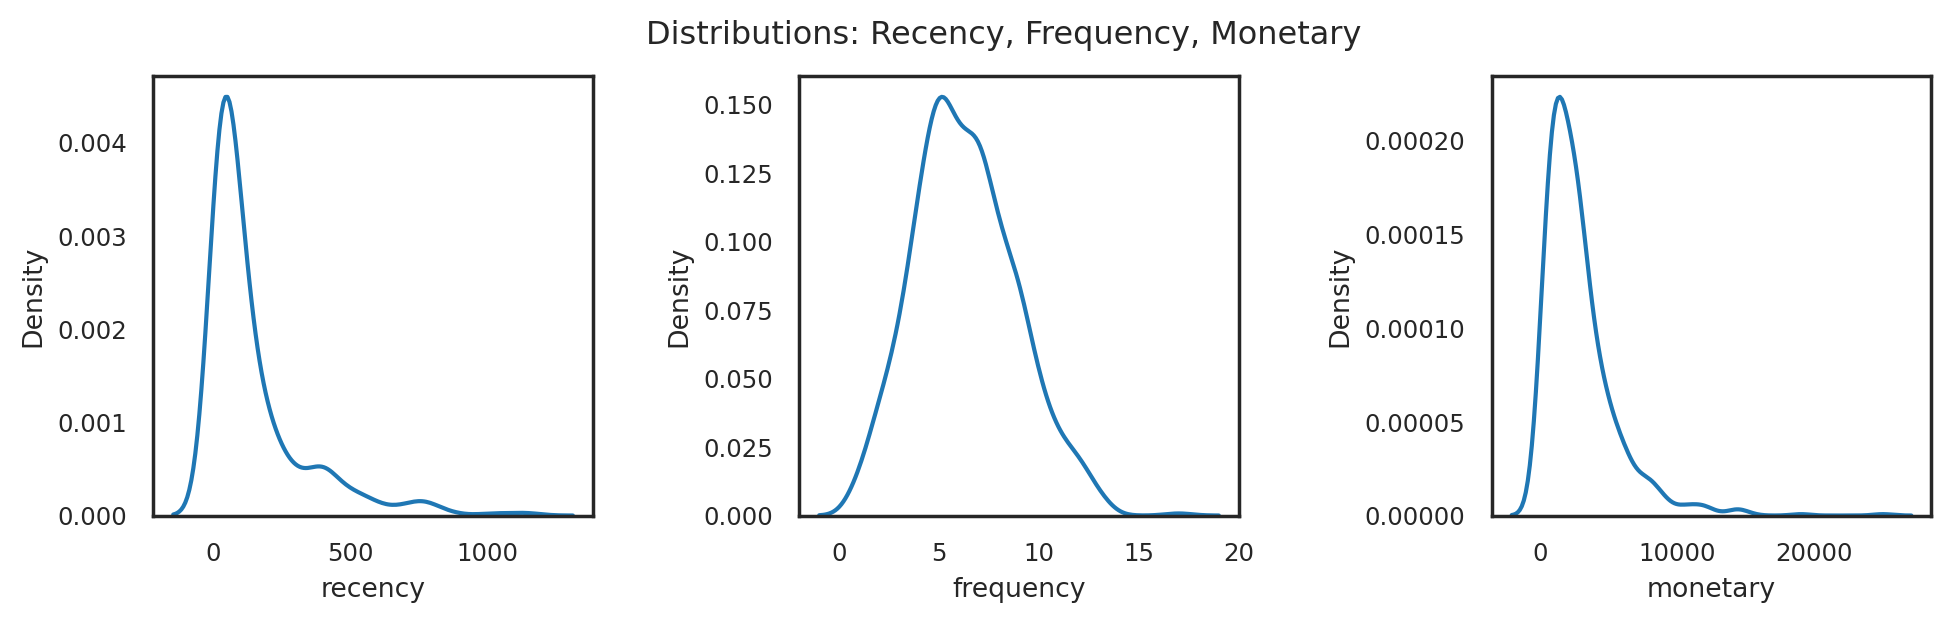

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), layout="constrained")
fig.suptitle('Distributions: Recency, Frequency, Monetary')

sns.kdeplot(rfm.recency, ax=ax[0],)
ax[0].set_box_aspect(1)
sns.kdeplot(rfm.frequency, ax=ax[1])
ax[1].set_box_aspect(1)
sns.kdeplot(rfm.monetary, ax=ax[2])
ax[2].set_box_aspect(1)

# plt.axvline(rfm.recency.mean(), c='gray')
# plt.axvline(rfm.recency.median())


Above we see the tall thin skewed distributions with possible outliers. Below we can see the outliers more clearly:

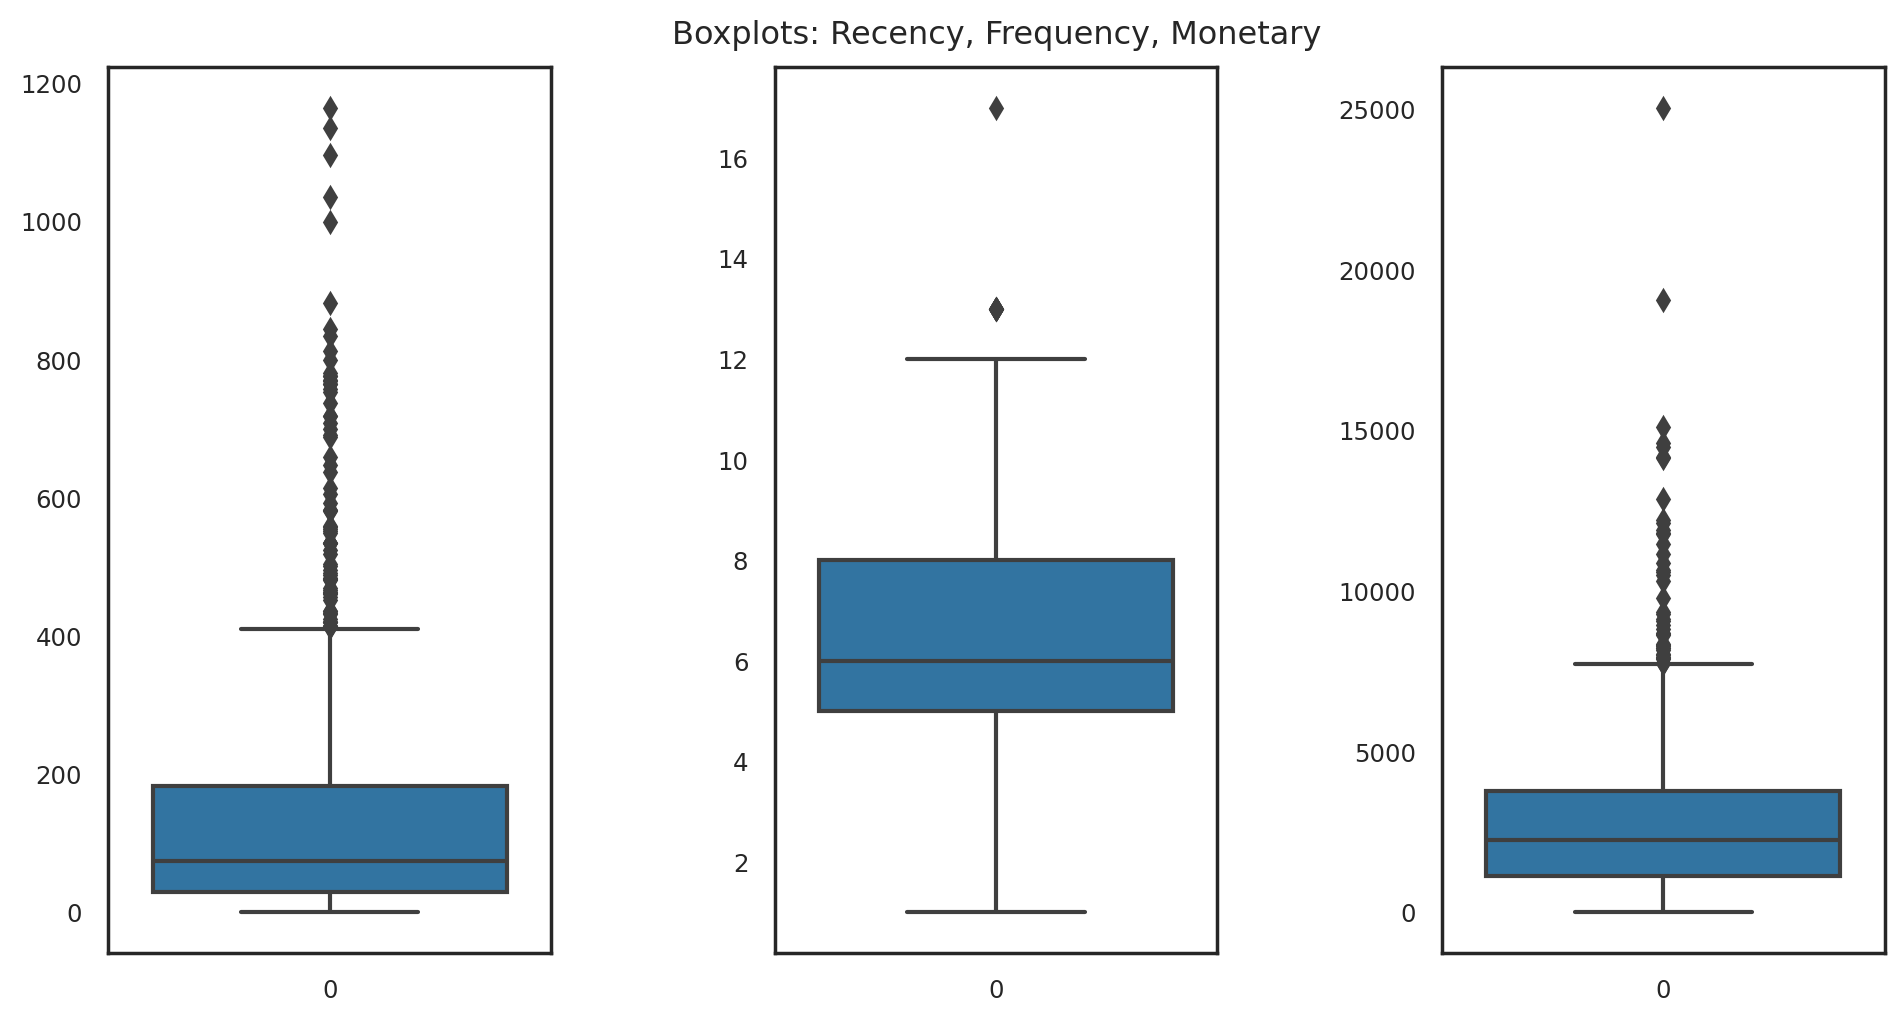

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5), layout="constrained")
fig.suptitle('Boxplots: Recency, Frequency, Monetary')

sns.boxplot(rfm.recency, ax=ax[0],)
ax[0].set_box_aspect(2)
sns.boxplot(rfm.frequency, ax=ax[1])
ax[1].set_box_aspect(2)
sns.boxplot(rfm.monetary, ax=ax[2])
ax[2].set_box_aspect(2)

Pair correlations:

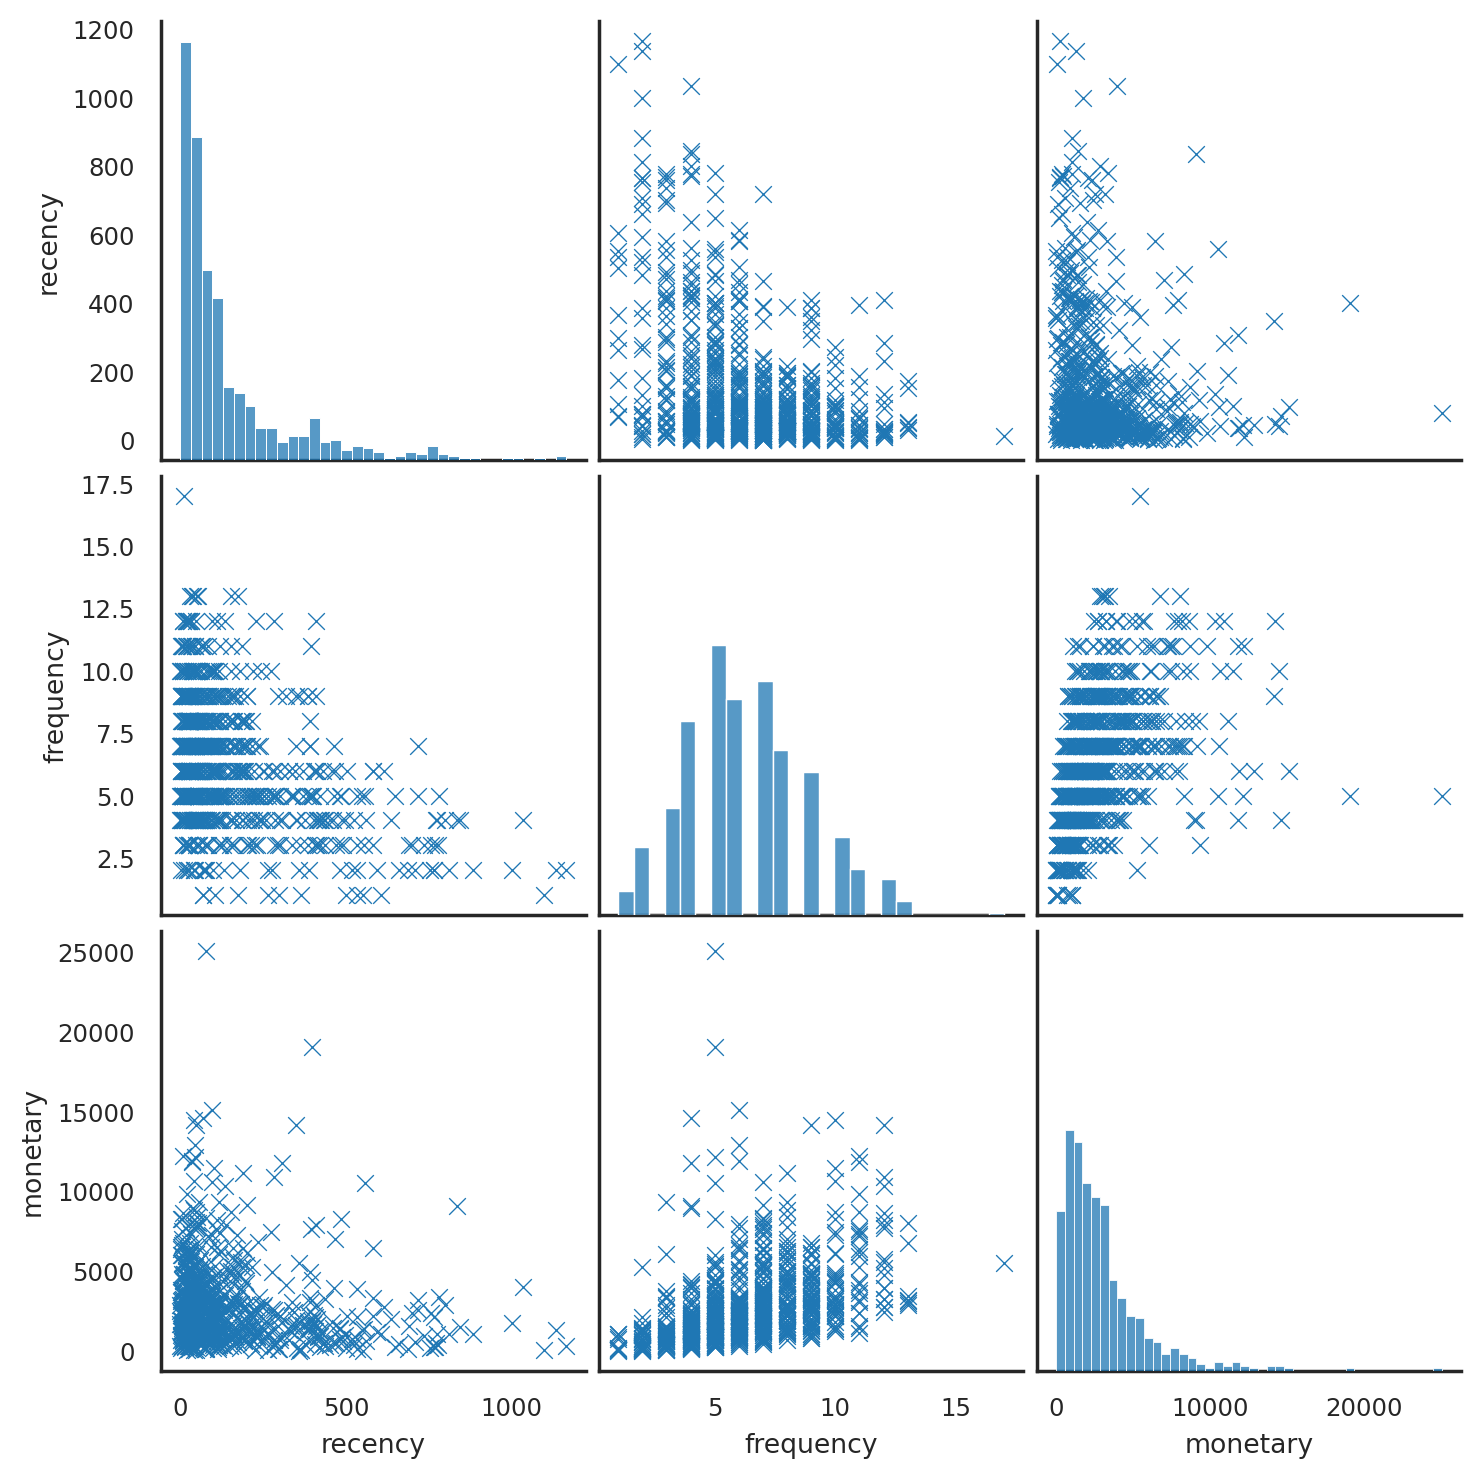

In [13]:
sns.pairplot(rfm, markers="x")

#### Null values and datatypes:

In [14]:
print(rfm.isnull().sum())

recency      0
frequency    0
monetary     0
dtype: int64


In [15]:
rfm.dtypes

recency        int64
frequency      int64
monetary     float64
dtype: object

#### Summary and requirements:

We can see that:
- The distribution is positively skewed (especially for recency and monetary data) and unimodal
- The fields all have very different scales
- Outliers are present
- There are no customers with missing or negative values
- The datatypes are correct

Note that this is for our aggregated data, so anomolies such as individual negative values would be hidden. We may wish to clean unaggregated data first in the event of poor convergence.  

KMeans:
- Works best with normal distribution
- Assumes data is all on a similar scale (because the algorithm is distance-based)

Before preprocessing the data, let's run the model to see how it deals with the imperfections.

## 3. Run K-Means model on unprocessed data

### Initialise first K-Means model

In [16]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f365c7d8f70>
Traceback (most recent call last):
  File "/home/sian/anaconda3/envs/stats_env/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/sian/anaconda3/envs/stats_env/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/sian/anaconda3/envs/stats_env/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/sian/anaconda3/envs/stats_env/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f362d67ff70>
Traceback (most recent call last):
  File "/home/sian/anaconda3/envs/stats_env/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/sian/anaconda3/envs/stats_env/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/sian/anaconda3/envs/stats_env/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/sian/anaconda3/envs/stats_env/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

KMeans(max_iter=50, n_clusters=4)

Now the model is trained we can view the list of labels it chose for each data point:

In [17]:
label_list=kmeans.labels_
label_list

array([1, 0, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 0, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0,
       2, 0, 2, 0, 1, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1,
       2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0,
       1, 0, 3, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 3, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 0, 2, 2, 3,
       2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 3, 2,
       0, 0, 0, 2, 0, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0,
       0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 2, 0, 2, 0, 1, 0,
       0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 3, 0, 0, 0, 2, 0, 2,
       2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1,
       2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0,

### Evaluating first result:

Now we can run a silhouette anlaysis and graph the results to view the fit of the centroids. `silhouette_samples` calculates the coefficient for each point and `silhouette_score` is the mean for all samples.

In [18]:
#silhouette score for model when run on non-standardised data
sil_score_model_un = metrics.silhouette_score(rfm, label_list, metric='euclidean')
print('Silhoutte Score of a randomly initialised K-Means model with 4 clusters on unstandardised RFM data: {}'.format(round(sil_score_model_un, 3)))

Silhoutte Score of a randomly initialised K-Means model with 4 clusters on unstandardised RFM data: 0.558


Text(0, 0.5, 'Cluster number')

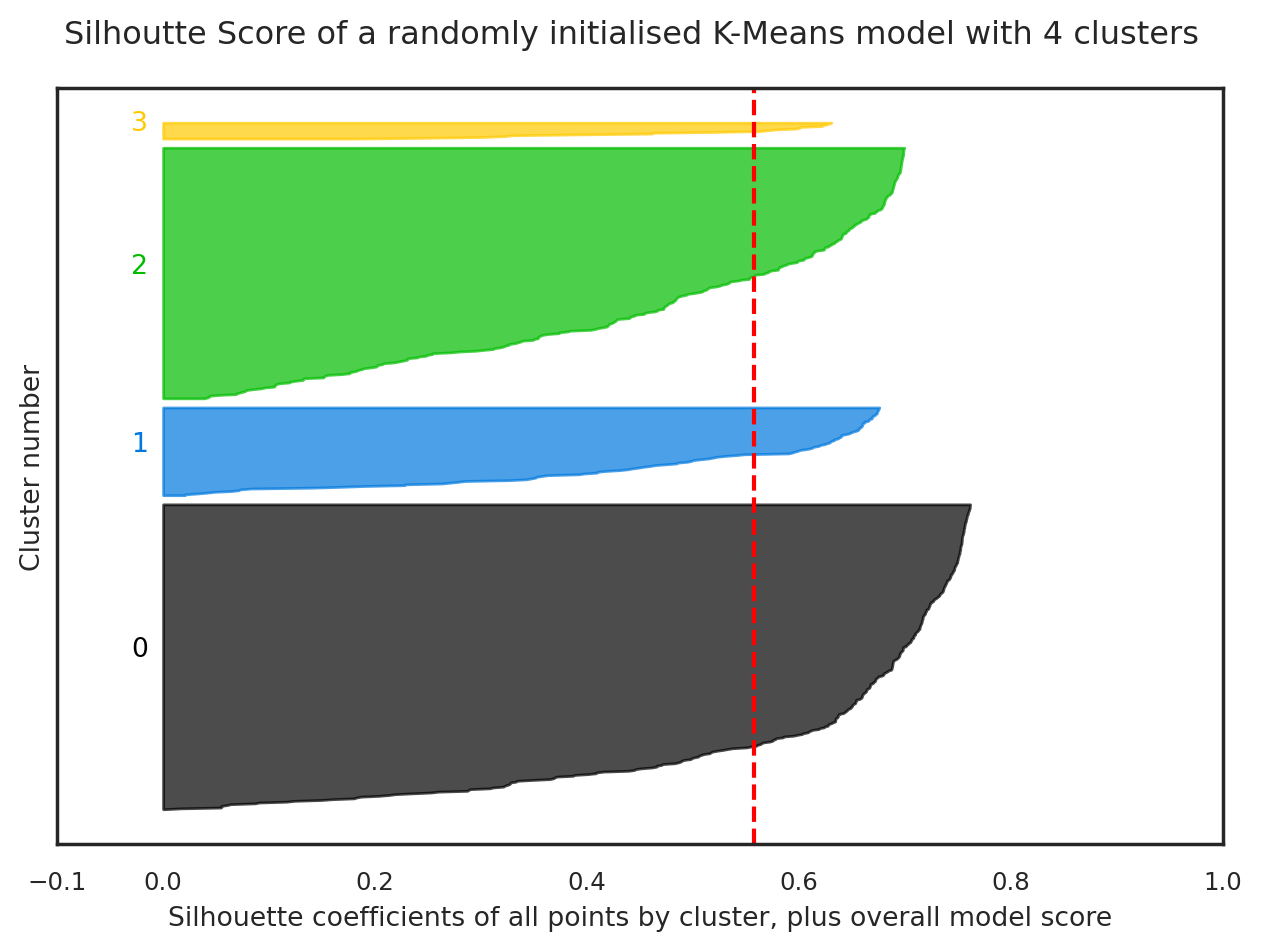

In [19]:
#make a single silhouette graph. modified from specs: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#
model = kmeans
sample_silhouette_values = silhouette_samples(rfm, label_list)
u_labels = np.unique(label_list) 
n_clusters0 = 4

y_lower = 0
fig, ax = plt.subplots(layout='tight')
for i in [0,1,2,3]:
        # Aggregate the silhouette scores for each cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[label_list == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters0)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color= cm.nipy_spectral(float(i) / n_clusters0)) # axis cluster labels
        y_lower = y_upper + 10 

ax.set_yticks([])  # rm y-axis labels 
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
ax.axvline(x=sil_score_model_un, color="red", linestyle="--") # add the model silhouette score as an average line

fig.suptitle("Silhoutte Score of a randomly initialised K-Means model with 4 clusters")
ax.set_xlabel("Silhouette coefficients of all points by cluster, plus overall model score")
ax.set_ylabel("Cluster number")


In [20]:
# find maximum silhouette score for up to kN clusters
# for i in [2,3,4,5]:
#     km0 = KMeans(n_clusters=i, random_state=8)
#     km0.fit(rfm)
#     sil_scores = [silhouette_score(km0, km0.labels_)]

In [21]:
#silhouette graph, source : https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111 - 
#doesn't work. there is no model fit included. indentation also possibly broken

#### later: Comparing pairwise distance metrics
As our data is not scaled, maybe another distance metric will work? Let's examine the options: https://scikit-learn.org/0.15/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html

In [22]:
metrics.silhouette_score(rfm, label_list, metric='correlation')

-0.6616755883343118

~~We can then apply the cluster numbers to our customers as a new column in the `rfm` dataframe:~~

In [23]:
#not going to do this yet as I'm going to run the model multiple times
# rfm['cluster_id'] = kmeans.labels_
# rfm.head()

### Visualising the clusters

Text(0.5, 0, 'Temp')

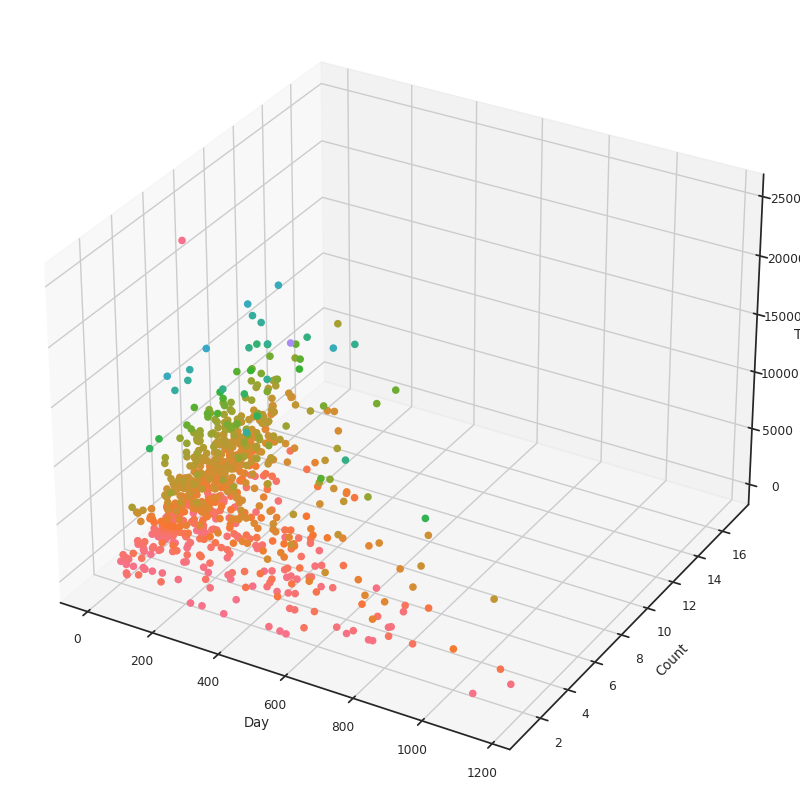

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

In [ ]:
# data columns
x = rfm.recency
y = rfm.frequency
z = rfm.monetary

# invoke ipympl magic to view embedded interactive graph
%matplotlib ipympl

# get colours
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# fig and axes instances in 3D
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
fig.add_axes(ax)

# plot
sc = ax.scatter(x, y, z, c=z, cmap=cmap, alpha=1)
ax.set_xlabel("Day")
ax.set_ylabel("Count")
ax.set_zlabel("Temp")

## 2. Clean/preprocess data

### Outliers

In [25]:
#use IQR

### Feature scaling: Z-Score Standardisation
Standardisation allows us to compare features' values on a similar scale. This is done typically so that mean of all data types becomes 0, and the scale is based on the unit variance from this new mean. 

StandardScaler() requires a normal gaussian distribution.

In [26]:
# # Rescaling the attributes
# rfm_df = rfm[['Expenditure', 'Frequency', 'Recency']]

# # Instantiate
# scaler = StandardScaler()

# # fit_transform
# rfm_df_scaled = pd.DataFrame(scaler.fit_transform(rfm_df)) #change back if doesn't work
# rfm_df_scaled.columns = ['Expenditure', 'Frequency', 'Recency']
# rfm_df_scaled.head()

###  Later: 

#### pick out better scalers here? 
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

#### Principal component analysis (PCA)
if using more dimensions

#### more steps: 
polynomial (preprocessing) https://scikit-learn.org/stable/modules/preprocessing.html#polynomial-features



In [27]:
#maybe for further cleaning before agg
# rfm = rfm[(rfm['monetary'] > 0)]
# rfm = rfm.reset_index()

## 3. Run K-Means model on normalised data

### Initialise K-Means model

In [28]:
# kmeans = KMeans(n_clusters=4, max_iter=50)
# kmeans.fit(rfm_df_scaled)

## 4. Optimise the number of clusters (k)
K-means is sensitive not only to the placement but also to the number of clusters. The Elbow Method and Silhouette Score can help us find the best number to fit the data well but without overfitting.

### Elbow method

In [29]:
#calculate and graph...

### Silhouette score

In [30]:
# kmeans = KMeans(n_clusters = 3, random_state = 42)
# kmeans.fit(kmeans_data)
# print('Silhoutte Score for scaled data: {}'.format(round(metrics.silhouette_score(kmeans_data, kmeans.labels_), 3))) 

### Compare performance of base model to model using `k-means++` 

K-means is sensitive not only to the number of clusters but also their initial placement. We already accounted for this by repeating the clustering with new random starting points each time. Scikit learn also provides a method to try to deal with this problem. Setting the k-means++ hyperparameter in scikit-learn will initialise centroids that are spread-out rather than random. 

As the silhouette score measures the separation between clusters, we can measure the impact of the method's attempt to spread the initial centroids.

## 5. Run k-optimised K-Means model and visualise results

In [31]:
#run

In [32]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

ValueError: Could not interpret input 'Cluster_Id'

## Last: also try:

K-Medoids
https://medium.com/@ali.soleymani.co/beyond-scikit-learn-is-it-time-to-retire-k-means-and-use-this-method-instead-b8eb9ca9079a

Affinity propogation https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation

Density-based algorithms like DBSCAN use the density of data points to form clusters.
